In [2]:
import h5py
import os
import time
import platform
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
from matplotlib import colors
import pyresample
import netCDF4 as nc
# %pylab inline
%matplotlib inline
try:
    exc = None
    from mpl_toolkits.basemap import Basemap
except Exception as exc:
    print(exc)
    pass



## Generate List

In [3]:
import os
import glob
os.chdir('H:\gOOLE')
path = 'H:\gOOLE'

In [68]:
datalist=glob.glob('*L2A*.h5')

In [69]:
datalist

['H1C_OPER_OCT_L2A_20211109T023000_20211109T023500_16617_10.h5',
 'H1C_OPER_OCT_L2A_20211110T015500_20211110T020000_16631_10.h5',
 'H1C_OPER_OCT_L2A_20211110T020000_20211110T020500_16631_10.h5',
 'H1C_OPER_OCT_L2A_20211110T020000_20211110T020500_16639_10.h5',
 'H1C_OPER_OCT_L2A_20211110T034000_20211110T034500_16632_10.h5',
 'H1C_OPER_OCT_L2A_20211110T034000_20211110T034500_16639_10.h5',
 'H1C_OPER_OCT_L2A_20211111T012500_20211111T012947_16645_10.h5',
 'H1C_OPER_OCT_L2A_20211111T030500_20211111T031000_16646_10.h5',
 'H1D_OPER_OCT_L2A_20211108T034500_20211108T035000_07389_10.h5',
 'H1D_OPER_OCT_L2A_20211108T052500_20211108T053000_07396_10.h5',
 'H1D_OPER_OCT_L2A_20211109T045000_20211109T045500_07404_10.h5',
 'H1D_OPER_OCT_L2A_20211109T045000_20211109T045500_07410_10.h5',
 'H1D_OPER_OCT_L2A_20211109T045500_20211109T050000_07404_10.h5',
 'H1D_OPER_OCT_L2A_20211109T045500_20211109T050000_07410_10.h5',
 'H1D_OPER_OCT_L2A_20211110T042000_20211110T042500_07426_10.h5',
 'H1D_OPER_OCT_L2A_202111

## Read variable

In [6]:
f1=datalist[0]
f = h5py.File(f1, 'r') # open for read only
keys = '\n'.join(f.keys()) # Generate a string of root folders 
print(keys) # display "\n" splits each folder into a new line on print

Geophysical Data
Navigation Data
Scan Line Attributes
Sensor Band Parameters


In [8]:
for key in f.keys():
    attrs = f[key].attrs
    print('\n'.join(['~' * len(key), key, '~' * len(key)]))
    items = [f'\t{key}: {val[0]}\n' for (key, val) in attrs.items()]
    print(''.join(items))

~~~~~~~~~~~~~~~~
Geophysical Data
~~~~~~~~~~~~~~~~

~~~~~~~~~~~~~~~
Navigation Data
~~~~~~~~~~~~~~~
	First Navigation Point: 1
	Navigation Points: 1656
	Pixel-intervals of Navigation Points: 1

~~~~~~~~~~~~~~~~~~~~
Scan Line Attributes
~~~~~~~~~~~~~~~~~~~~

~~~~~~~~~~~~~~~~~~~~~~
Sensor Band Parameters
~~~~~~~~~~~~~~~~~~~~~~



In [9]:
for key in f.keys():
    vars_ = f[key]
    print('\n'.join(['~' * len(key), key, '~' * len(key)]))
    vars_ = [f'\t{key}\n' for key in vars_.keys()]
    print(''.join(vars_))

~~~~~~~~~~~~~~~~
Geophysical Data
~~~~~~~~~~~~~~~~
	Rrs412
	Rrs443
	Rrs490
	Rrs520
	Rrs565
	Rrs670
	Rrs750
	Rrs865
	eps78
	l2_flags
	la670
	la750
	la865
	taua865

~~~~~~~~~~~~~~~
Navigation Data
~~~~~~~~~~~~~~~
	Latitude
	Longitude

~~~~~~~~~~~~~~~~~~~~
Scan Line Attributes
~~~~~~~~~~~~~~~~~~~~
	Center Latitude
	Center Longitude
	Center Solar Zenith Angle
	Day
	End Latitude
	End Longitude
	Millisecond
	Start Latitude
	Start Longitude
	Year

~~~~~~~~~~~~~~~~~~~~~~
Sensor Band Parameters
~~~~~~~~~~~~~~~~~~~~~~
	F0
	Syscal Gain
	Syscal Offset
	Wavelength
	k_oz
	tau_r



In [10]:
key, var = 'Sensor Band Parameters', 'Wavelength'
sds_obj = f[f'{key}/{var}']
# We can also inspect CHLA attributes
np.array(sds_obj)

array([412, 443, 490, 520, 565, 670, 750, 865])

In [11]:
dn = sds_obj[:]
print(dn)

[412 443 490 520 565 670 750 865]


In [53]:

def HY1CD_Rrs_Reader(file:str):
    f = h5py.File(file, 'r')
    Rrs=['Rrs412',
    'Rrs443','Rrs490','Rrs520','Rrs565','Rrs670','Rrs750','Rrs865']
    Rrs_output = {'Rrs412': [],
       'Rrs4443': [],
       'Rrs490': [],
       'Rrs520': [],
       'Rrs560': [],
       'Rrs670': [],
       'Rrs750': [],
       'Rrs865': [],}
    key = 'Geophysical Data'
    for i in range(0, 8):
        var =Rrs[i]
        sds_obj = f[f'{key}/{var}']
        dn_attrs = sds_obj.attrs
        dn = sds_obj[:]
        slope = dn_attrs['Slope'][0]
        offset = dn_attrs['Offset'][0]
        min_val = dn_attrs['ValidMin'][0]
        max_val = dn_attrs['ValidMax'][0]
        fill_val = dn_attrs['FillValue'][0]
        varvalue = dn * slope + offset
            # Here do not mask minus and zero value of Rrs, you can active it if you want
        varvalue=np.ma.masked_where(varvalue <0., varvalue)
        key2,var2='Sensor Band Parameters', 'Wavelength'

        wave = np.array(f[f'{key2}/{var2}'])
        Rkey = 'Rrs' + str(wave[i])
        Rrs_output[Rkey] = varvalue
    f.close()
    return Rrs_output
Rrs=HY1CD_Rrs_Reader(f1)

## Read Lon Lat 

In [54]:
key='Navigation Data'
var='Longitude'
Lons=np.array(f[f'{key}/{var}'])

In [55]:
Lons

array([[108.60833 , 108.71153 , 108.79923 , ..., 148.32684 , 148.39972 ,
        148.47327 ],
       [108.61128 , 108.708305, 108.80373 , ..., 148.31293 , 148.38576 ,
        148.45924 ],
       [108.61851 , 108.70421 , 108.805916, ..., 148.29906 , 148.37181 ,
        148.44525 ],
       ...,
       [107.7967  , 107.869995, 107.94317 , ..., 138.6532  , 138.71605 ,
        138.77951 ],
       [107.80762 , 107.86959 , 107.93932 , ..., 138.64505 , 138.70787 ,
        138.7713  ],
       [107.80724 , 107.86554 , 107.92949 , ..., 138.63693 , 138.6997  ,
        138.7631  ]], dtype=float32)

In [56]:
key='Navigation Data'
var='Latitude'
Lats=np.array(f[f'{key}/{var}'])

In [57]:
Lats

array([[50.497116, 50.497963, 50.49864 , ..., 43.505802, 43.47701 ,
        43.447876],
       [50.47653 , 50.47739 , 50.47816 , ..., 43.488213, 43.459385,
        43.430214],
       [50.455975, 50.456806, 50.45768 , ..., 43.470615, 43.441746,
        43.412537],
       ...,
       [31.972656, 31.967129, 31.961569, ..., 25.787981, 25.767294,
        25.74637 ],
       [31.95109 , 31.946486, 31.941248, ..., 25.769024, 25.74829 ,
        25.727318],
       [31.930405, 31.92612 , 31.92138 , ..., 25.750061, 25.729279,
        25.708258]], dtype=float32)

## Resample

In [58]:
def swath_resampling(src_data:np.ma.array, src_lon:np.array, src_lat:np.array,  
                     trg_lon:np.array, trg_lat:np.array, search_radius:float):
        
    if len(trg_lon.shape) == 1:
        grid_def = pyresample.geometry.SwathDefinition(*np.meshgrid(trg_lon, trg_lat))
    else:
        grid_def = pyresample.geometry.SwathDefinition(lons=trg_lon, lats=trg_lat)
    
    # source grid with original swath data
    swath_def = pyresample.geometry.SwathDefinition(lons=src_lon, lats=src_lat)
    
    # resample (here we use nearest. Bilinear, gaussian and custom defined methods are available)
    # for more, visit https://pyresample.readthedocs.io/en/latest/
    result = pyresample.kd_tree.resample_nearest(swath_def, src_data, grid_def, epsilon=0.5, 
                                                 fill_value=None, radius_of_influence=search_radius)
    return result, grid_def   

In [59]:
%%time
# create a new regular grid (for the output data)
x = np.arange(120.5591, 125.7544, .01) # 1 km grid, full resolution did not work but 500 m was OK!
y = np.arange(35.9717, 29.4873, -.01)


var_re, grid = swath_resampling(Rrs['Rrs412'], Lons, Lats, x, y, 5000)

Wall time: 695 ms


(array([[2016.,    0.,    0., ...,    0.,    0.,    0.],
        [2016.,    0.,    0., ...,    0.,    0.,    0.],
        [2016.,    0.,    0., ...,    0.,    0.,    0.],
        ...,
        [2016.,    0.,    0., ...,    0.,    0.,    0.],
        [2016.,    0.,    0., ...,    0.,    0.,    0.],
        [2016.,    0.,    0., ...,    0.,    0.,    0.]]),
 array([0.        , 0.00233048, 0.00466096, 0.00699145, 0.00932193,
        0.01165241, 0.0139829 , 0.01631338, 0.01864386, 0.02097434,
        0.02330483], dtype=float32),
 <a list of 1656 Lists of Patches objects>)

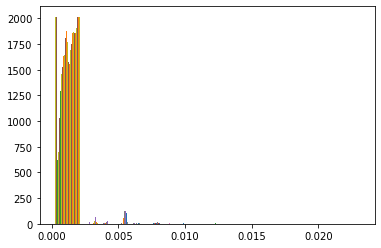

In [60]:
plt.hist(Rrs['Rrs412'])

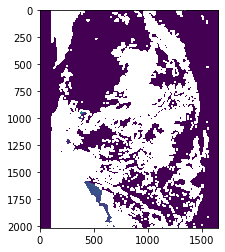

In [61]:
plt.imshow(Rrs['Rrs412'])

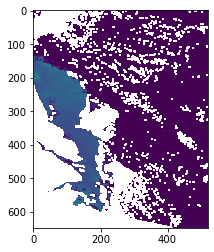

In [62]:
plt.imshow(var_re)

(array([[ 87.,   0.,  15., ...,   0.,   0.,   0.],
        [ 90.,   0.,  16., ...,   0.,   0.,   0.],
        [ 94.,   3.,  22., ...,   0.,   0.,   0.],
        ...,
        [640.,   3.,   0., ...,   0.,   0.,   0.],
        [640.,   2.,   0., ...,   0.,   0.,   0.],
        [642.,   0.,   0., ...,   0.,   0.,   0.]]),
 array([0.        , 0.00190733, 0.00381465, 0.00572198, 0.00762931,
        0.00953663, 0.01144396, 0.01335128, 0.01525861, 0.01716594,
        0.01907326], dtype=float32),
 <a list of 520 Lists of Patches objects>)

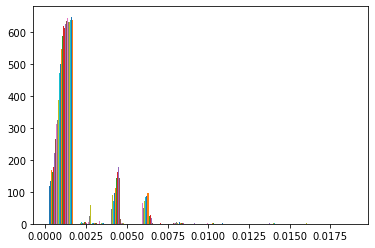

In [63]:
plt.hist(var_re)

In [64]:
var_re.min()

0.0

In [65]:
def plot_geo_image(sds:np.ma.array, lon:np.ndarray, lat:np.ndarray, log10:bool=True, title:str=None, label:str=None,
                   caxis:list=None, lon_range:list=None, lat_range:list=None, save_image:str=None, dpi:int=100):
    
    if len(lon.shape) == 1:
        print('MeshGridding...')
        lon, lat = np.meshgrid(lon, lat)
    
    lon_0 = (lon.min() + lon.max()) / 2
    lat_0 = (lat.min() + lat.max()) / 2
    
    print(f'Lat: [{lat.min():.3f}, {lat.max():.3f}] | '
          f'Lon: [{lon.min():.3f}, {lon.max():.3f}] | '
          f'SDS: [{sds.min():.3f}, {sds.max():.3f}]')
    
    if (lon_range is not None) and (lat_range is not None):
        m = Basemap(llcrnrlon=min(lon_range), llcrnrlat=min(lat_range), 
                    urcrnrlon=max(lon_range), urcrnrlat=max(lat_range), 
                    resolution='i', lon_0=lon_0, lat_0=lat_0, projection='tmerc')
    else:
        m = Basemap(llcrnrlon=lon.min(), llcrnrlat=lat.min(), 
                    urcrnrlon=lon.max(), urcrnrlat=lat.max(), 
                    resolution='i', lon_0=lon_0, lat_0=lat_0, projection='tmerc')
    x2d, y2d = m(lon, lat)

    fig = plt.figure(figsize=(8, 8 * m.aspect))
    ax = fig.add_axes([0.08, 0.1, 0.7, 0.7], facecolor='white') 
    # changed to facecolor 8 October 2019
    
    if (lon_range is not None) and (lat_range is not None):
        parallels = np.linspace(min(lat_range), max(lat_range), 4)
        meridians = np.linspace(min(lon_range), max(lon_range), 3)
    else:
        parallels = meridians = None
    
    if caxis is not None:
        cmn, cmx = min(caxis), max(caxis)
    else:
        cmn, cmx = sds.min(), sds.max()

    ncl = 150
    if log10 is True:
        norm = colors.LogNorm(vmin=cmn, vmax=cmx)
    else:
        bounds = np.linspace(cmn, cmx, ncl)
        norm = colors.BoundaryNorm(boundaries=bounds, ncolors=ncl)
    
    p = m.pcolor(x2d, y2d, sds, norm=norm, cmap=plt.cm.jet) 
    
    if title is not None:
        plt.title(title)
        
    # divider = make_axes_locatable(ax)
    # cax = divider.append_axes('vertical', size="3%", pad=0.05)
    cax = plt.axes([0.85, 0.1, 0.05, 0.7]) # setup colorbar axes
    
    cb = plt.colorbar(format='%5.2f', cax=cax) # draw colorbar
    if label is not None:
        cb.set_label("%s" % label)
    plt.sca(ax)  # make the original axes current again
    plt.clim(cmn, cmx)
    
    m.drawcoastlines()
    m.drawcountries()
    plt.show()
    
    if save_image is not None:
        plt.savefig(save_image, dpi=dpi, facecolor='w', edgecolor='w', orientation='portrait')
        plt.show()
        plt.close()

Lat: [29.492, 35.972] | Lon: [120.559, 125.749] | SDS: [0.000, 0.019]


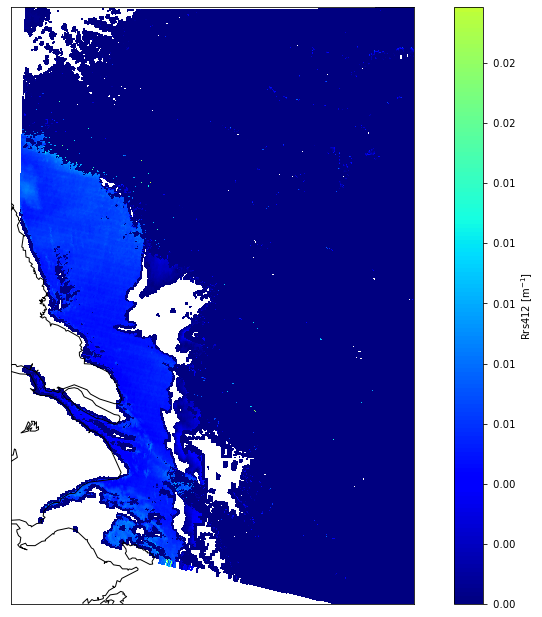

Wall time: 7.27 s


In [67]:
%%time
lon_grid, lat_grid = grid.get_lonlats()
plot_geo_image(var_re, lon_grid, lat_grid, label='Rrs412 [m$^{-1}$]',log10=False)
f.close() # from now on, we no longer need the hdf5 file, so we close it

In [34]:
type(var_re)

numpy.ma.core.MaskedArray

In [35]:
var_re>0

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=3.4028235e+38)

In [39]:
x

array([107.78466797, 107.79466797, 107.80466797, ..., 148.44466797,
       148.45466797, 148.46466797])

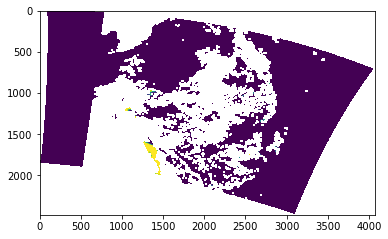

In [42]:
plt.imshow(var_re>0)


In [43]:
f

<HDF5 file "H1C_OPER_OCT_L2A_20211109T023000_20211109T023500_16617_10.h5" (mode r)>